In [1]:
import csv
import json
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import random
from collections import deque
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import load_model

In [2]:
#NEW DATA TEST
caiso=pd.read_csv("/Users/john_schafer/Downloads/CE291/Final_Project/CAISO_zone_1_.csv")

In [3]:
#Transform Data to our format
caiso['time'] = pd.to_datetime(caiso['time'])
caiso.set_index('time', inplace=True)

# Function to reshape the data
def reshape_data(df, column):
    # Resample data to daily frequency, and apply list to convert each day's data into a list
    daily_data = df[column].resample('D').apply(list)
    # Convert lists to a DataFrame, which inherently transposes the list to columns
    return pd.DataFrame(daily_data.tolist(), index=daily_data.index)

# Creating each DataFrame
demand_df = reshape_data(caiso, 'load_power')
solar_df = reshape_data(caiso, 'solar_power')
wind_df = reshape_data(caiso, 'wind_power')

def rename_columns(df):
    num_minutes = df.shape[1]
    time_labels = [str(pd.Timedelta(minutes=i)) for i in range(num_minutes)]
    df.columns = time_labels
    return df

demand_df = rename_columns(demand_df)
solar_df = rename_columns(solar_df)
wind_df = rename_columns(wind_df)

In [4]:

#Scaling 
# if power is normalized to 1, PEV dynamics in environment are run in kw
#max power of single Ev = 11 kw 
#max power of representative small microgrid of 5,000 people ~ 3.5 megawatts=3,500 kw
#multiply vby 3500 to get representative 
demand_caiso = np.array(demand_df)
solar_caiso = np.array(solar_df)*3 
wind_caiso = np.array(wind_df)*4 
net_caiso=demand_caiso-solar_caiso-wind_caiso

average_demand_per_minute = np.nanmean(demand_caiso, axis=0)
average_solar_per_minute = np.nanmean(solar_caiso, axis=0)
average_wind_per_minute = np.nanmean(wind_caiso, axis=0)

average_net_per_minute=average_demand_per_minute-average_solar_per_minute-average_wind_per_minute

In [8]:
average_demand_per_minute[:10]


array([0.87338896, 0.87282658, 0.87213257, 0.87143856, 0.87074456,
       0.87005055, 0.86935654, 0.86866254, 0.86796853, 0.86727452])

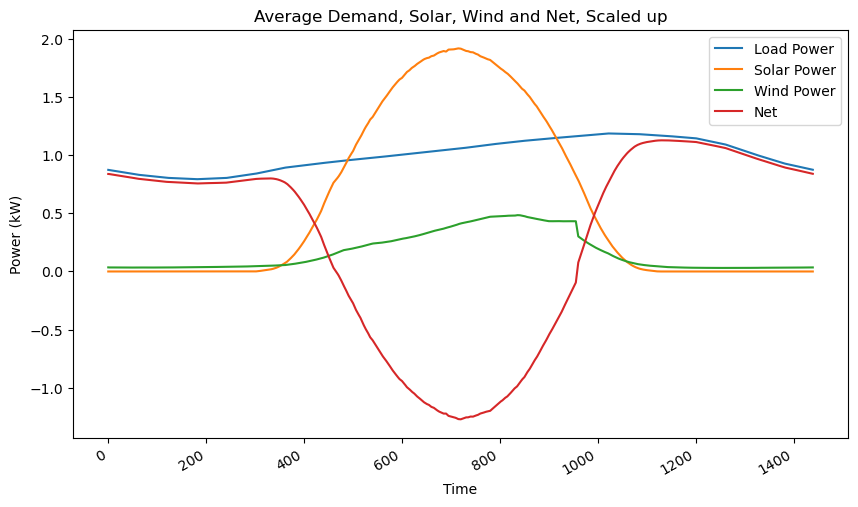

In [5]:
timestep_length=1 #in minutes
T=1440 # minutes in 24hrs

time_steps = np.arange(0, T * timestep_length, timestep_length)  # Generate a time axis\
plt.figure(figsize=(10, 6))
plt.plot(time_steps, average_demand_per_minute, label='Load Power')
plt.plot(time_steps, average_solar_per_minute, label='Solar Power')
plt.plot(time_steps, average_wind_per_minute, label='Wind Power')
plt.plot(time_steps, average_net_per_minute, label='Net')

# Adding titles and labels
plt.title('Average Demand, Solar, Wind and Net, Scaled up')
plt.xlabel('Time')
plt.ylabel('Power (kW)')
plt.legend()

# Rotating date labels for better visibility
plt.gcf().autofmt_xdate()

plt.show()

In [6]:
from DQL_RNN import DQNAgent
from env_rnn import GridEnvironment

In [7]:
average_demand_per_minute= average_demand_per_minute.reshape(1440,1).T
average_solar_per_minute=average_solar_per_minute.reshape(1440,1).T
average_wind_per_minute=average_wind_per_minute.reshape(1440,1).T


#Attempting to round: 
average_demand_per_minute_rd=np.round(average_demand_per_minute*10)/10 #Rounds each entry to nearest .1!
average_solar_per_minute_rd=np.round(average_solar_per_minute*10)/10
average_wind_per_minute_rd=np.round(average_wind_per_minute*10)/10

In [9]:
#testing over same "average" episode
#testing with simple RNN
#testing with rounded, "binned" energy profiles
#testing with 1 MEGA EV
import time
timestep_length=(1/60) #in hours
N=3
sequence_length=60 #In timesteps aka minutes
state_deque = deque(maxlen=sequence_length)

day_index=0
# Initialize DQN agent
agent = DQNAgent(state_size=7, action_size=(3**N), sequence_length=sequence_length)

episode_durations = []

for episode in range(1):  # Loop over 3 episodes of same "average" day
    # Initialize environment for the current day
    start_time = time.time()
    env = GridEnvironment(N, average_demand_per_minute_rd, average_solar_per_minute_rd, average_wind_per_minute_rd, day_index, timestep_length)
    
    total_reward = 0
    T = 1440  # Assume T timesteps in a day

    demand_profile = np.zeros(T)
    solar_profile = np.zeros(T)
    wind_profile = np.zeros(T)
    PEV_profile = np.zeros(T)

    for timestep in range(1, T+1):  # Loop through each timestep in the day
        normalized_timestep = np.array([timestep / T])   # T is the total number of timesteps in a day

        current_demand, current_solar, current_wind = env.get_state()
        current_P_EV=env.P_EV
        current_state=np.concatenate([np.array([current_demand, current_solar, current_wind]), np.array(current_P_EV), normalized_timestep])

        state_deque.append(current_state)
        state_history = np.array(state_deque)

        if len(state_deque) < sequence_length:
            continue  # Wait until deque is full before starting training
        
        action = agent.act(state_history)  # Decide action based on current state

        # Execute action in the environment and observe the next state, reward, and done flag
        reward, done, next_demand, next_solar, next_wind, next_P_EV = env.step(action)

        # Update profiles for plotting
        demand_profile[timestep - 1] = next_demand
        solar_profile[timestep - 1] = next_solar
        wind_profile[timestep - 1] = next_wind
        PEV_profile[timestep - 1] = np.sum(next_P_EV)
        
        normalized_next_timestep = np.array([(timestep+1) / T])
        # Construct the new state from the separated components
        next_state = np.concatenate([np.array([next_demand, next_solar, next_wind]), np.array(next_P_EV), normalized_next_timestep])
        
        # Directly learn from this transition without using replay
        agent.learn(state_history, action, reward, next_state, done)

        # Update state and total_reward
        #state = next_state why did I have this?
        total_reward += reward
        

        if done:
            # Handle episode completion, if applicable
            break

    print(f"Total reward for day {day_index}: {total_reward}")
    episode_durations.append(time.time() - start_time)
print("Individual episode durations:", episode_durations)



IndexError: index 1 is out of bounds for axis 0 with size 1

In [ ]:
demand_profile[:10]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

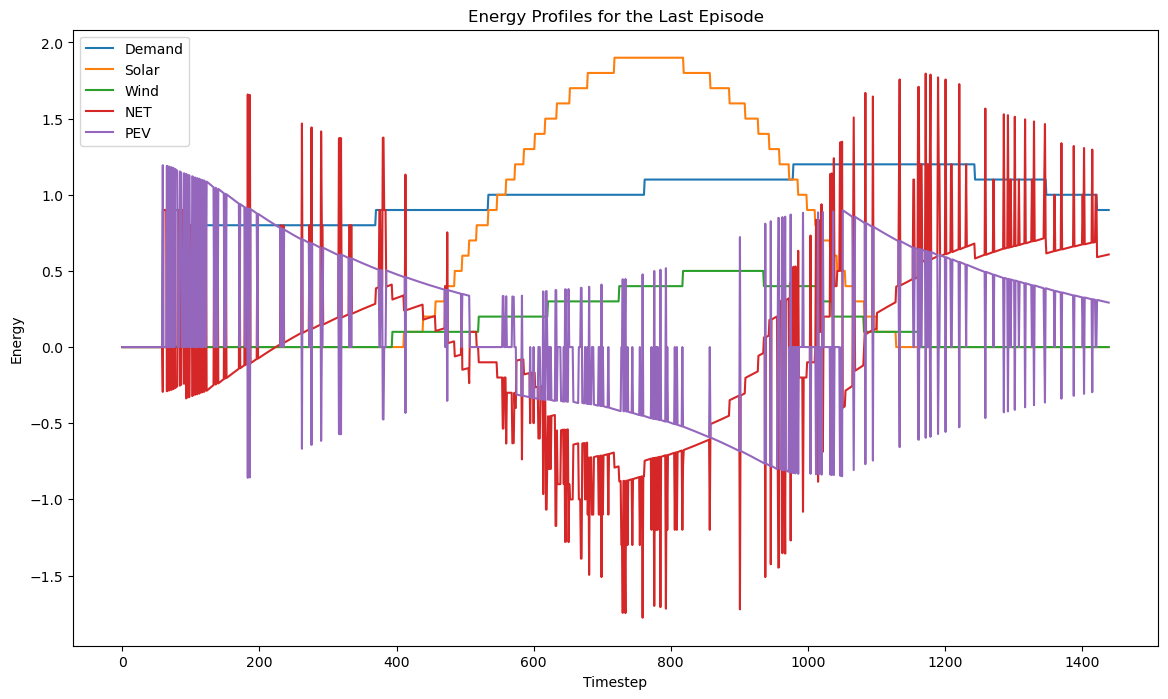

In [ ]:
plt.figure(figsize=(14, 8))
plt.plot(demand_profile, label='Demand')
plt.plot(solar_profile, label='Solar')
plt.plot(wind_profile, label='Wind')
plt.plot(demand_profile-solar_profile- wind_profile-PEV_profile, label='NET')
plt.plot(PEV_profile, label='PEV')
plt.legend()
plt.title('Energy Profiles for the Last Episode')
plt.xlabel('Timestep')
plt.ylabel('Energy')
plt.show()

In [ ]:
#USING AGENT W RNN ONE EPISODE
#also experimenting with adding time as a state

day_index=563 #random
timestep_length= (1/60) #in hours
N=10

sequence_length=120 #how far back LSTM looks back
state_deque = deque(maxlen=sequence_length)

env = GridEnvironment(N, demand_caiso, solar_caiso, wind_caiso, day_index, timestep_length)
agent = DQNAgent(state_size=env.state_size, action_size=env.action_size, sequence_length=sequence_length)

# Run for one episode (one day)
state = env.get_state()  # Reset environment to start state
total_reward = 0

T=1440 #(15 minute steps in 24 hrs)

demand_profile = np.zeros(T)
solar_profile = np.zeros(T)
wind_profile = np.zeros(T)
PEV_profile = np.zeros(T)

for timestep in range(1, T+1):  # Assume T timesteps in a day

    normalized_timestep = np.array([timestep / T])   # T is the total number of timesteps in a day

    current_demand, current_solar, current_wind = env.get_state()
    current_P_EV=env.P_EV
    current_state=np.concatenate([np.array([current_demand, current_solar, current_wind]), np.array(current_P_EV), normalized_timestep])

    state_deque.append(current_state)
    state_history = np.array(state_deque)

    if len(state_deque) < sequence_length:
        continue  # Wait until deque is full before starting training
    

    action = agent.act(state_history)  # Decide action based on current state

    # Execute action in the environment and observe the next state, reward, and done flag
    reward, done, next_demand, next_solar, next_wind, next_P_EV = env.step(action)


    # Update profiles for plotting
    demand_profile[timestep - 1] = next_demand
    solar_profile[timestep - 1] = next_solar
    wind_profile[timestep - 1] = next_wind
    PEV_profile[timestep - 1] = np.sum(next_P_EV)
    
    normalized_next_timestep = np.array([(timestep+1) / T])
    # Construct the new state from the separated components
    next_state = np.concatenate([np.array([next_demand, next_solar, next_wind]), np.array(next_P_EV), normalized_next_timestep])
    
    # Directly learn from this transition without using replay
    agent.learn(state_history, action, reward, next_state, done)

    # Update state and total_reward
    #state = next_state why did I have this?
    total_reward += reward
    

    if done:
        # Handle episode completion, if applicable
        break

print("Total reward for the episode (day):", total_reward)


55232
target_f: [[0.01177225 0.01446638 0.01186211 ... 0.00180605 0.00773425 0.01194122]]
53834
target_f: [[ 0.01110517  0.01450288  0.0137905  ...  0.00247622 -0.00123775
   0.01408305]]
15250
target_f: [[0.00941394 0.01330215 0.00852928 ... 0.00024092 0.00458335 0.01425735]]
target_f: [[0.02131466 0.00843566 0.00469489 ... 0.00143755 0.02375236 0.01279516]]
24181
target_f: [[0.01707856 0.00590207 0.01249189 ... 0.00458484 0.00685743 0.01992627]]
40020
target_f: [[0.02123228 0.02098672 0.02167845 ... 0.00382707 0.00210043 0.02404816]]
46778
target_f: [[-0.00648449  0.01748239  0.00821978 ... -0.00289     0.00517814
   0.03310647]]
53833
target_f: [[0.00058583 0.02266353 0.00687711 ... 0.00479702 0.00133221 0.01944483]]
2403
target_f: [[ 0.00614903  0.01202405  0.00374699 ... -0.00048886  0.00722211
   0.01243546]]
23850
target_f: [[0.01967046 0.01837784 0.0114025  ... 0.01318298 0.01663735 0.01497604]]
15999
target_f: [[-0.00878078 -0.00294104  0.0124832  ...  0.00488427  0.00473888
 

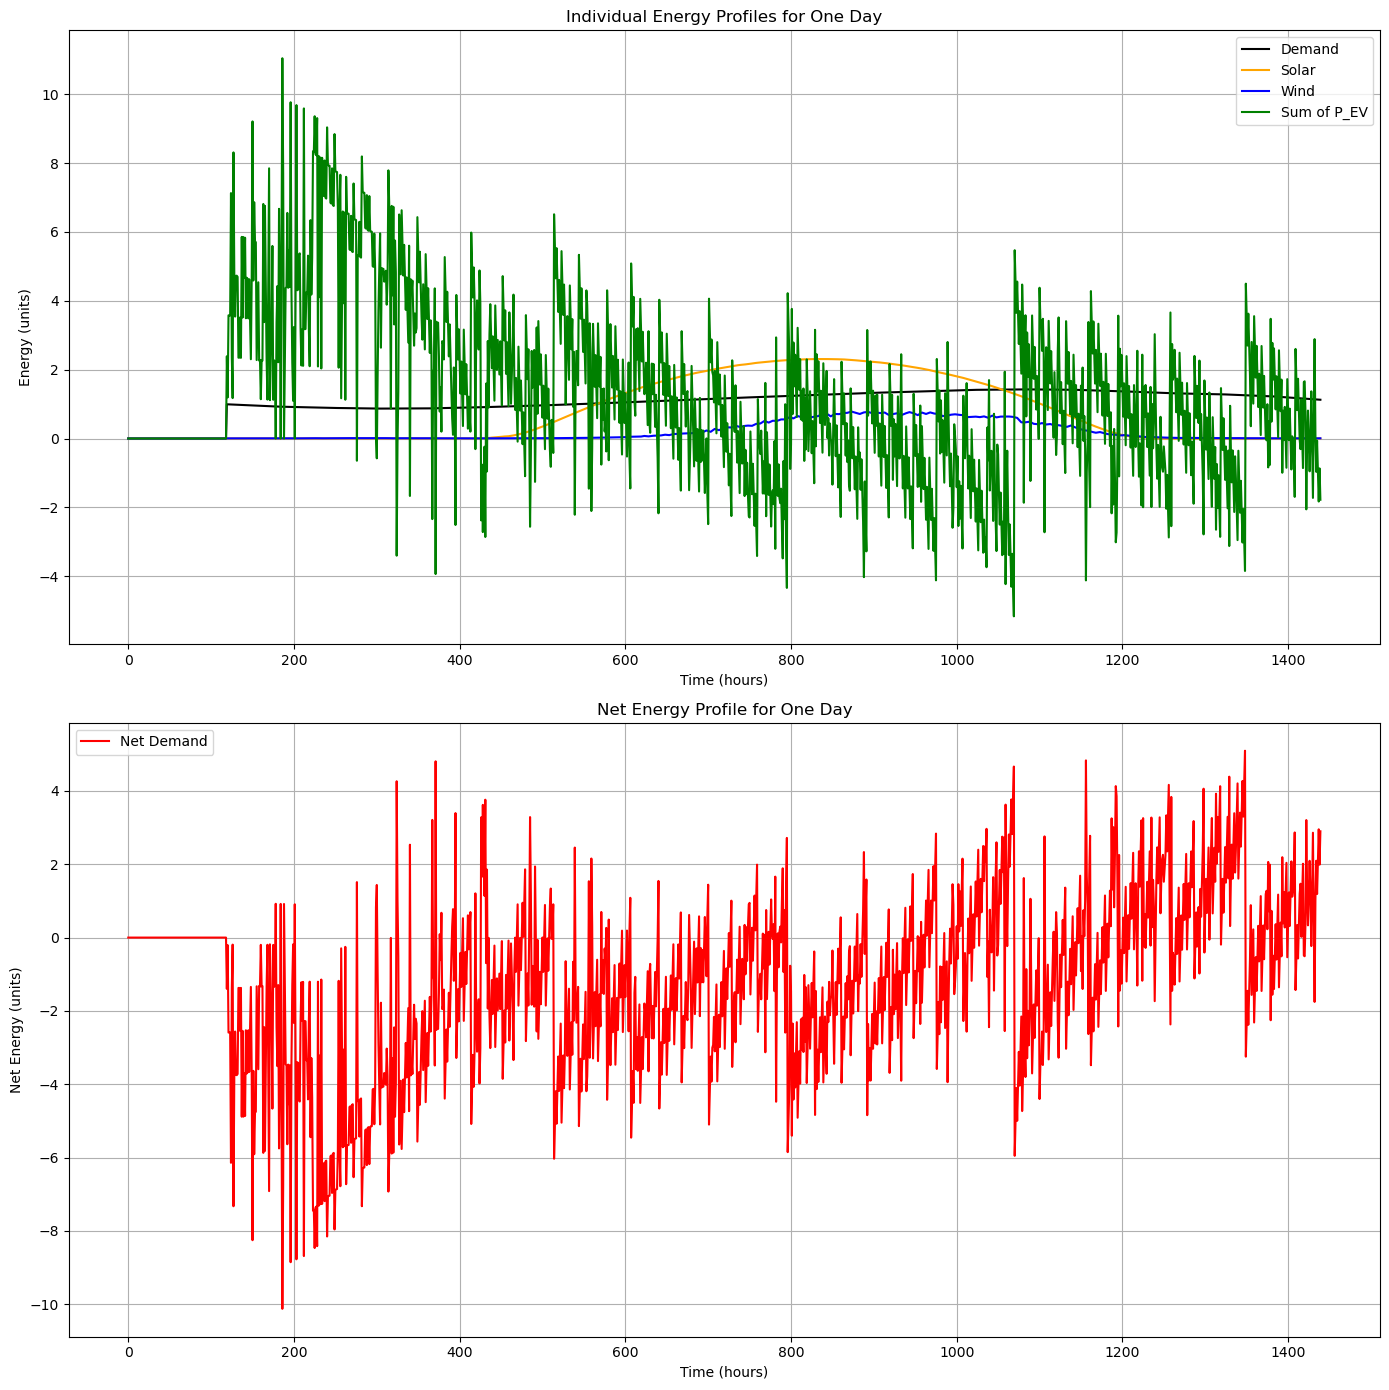

In [ ]:
#PLOT 1 Episode Test W/ LSTM
time_steps = np.arange(0, T, 1)  # Generate a time axis

plt.figure(figsize=(14, 14))  # Increase the figure size to accommodate two subplots

# First subplot for individual profiles
plt.subplot(2, 1, 1)  # (rows, columns, panel number)
plt.plot(time_steps, demand_profile, label='Demand', color='black')
plt.plot(time_steps, solar_profile, label='Solar', color='orange')
plt.plot(time_steps, wind_profile, label='Wind', color='blue')
plt.plot(time_steps, PEV_profile, label='Sum of P_EV', color='green')
plt.xlabel('Time (hours)')
plt.ylabel('Energy (units)')
plt.title('Individual Energy Profiles for One Day')
plt.legend()
plt.grid(True)

# Second subplot for net demand
plt.subplot(2, 1, 2)  # (rows, columns, panel number)
net_demand_profile = demand_profile - solar_profile - wind_profile-PEV_profile
plt.plot(time_steps, net_demand_profile, label='Net Demand', color='red')
plt.xlabel('Time (hours)')
plt.ylabel('Net Energy (units)')
plt.title('Net Energy Profile for One Day')
plt.legend()
plt.grid(True)

# Show both plots
plt.tight_layout()  # Adjusts subplot params so that subplots are nicely fit in the figure
plt.show()

In [ ]:
Total reward for day 0: -963.7514458798847
Total reward for day 0: -967.6963425596053
Total reward for day 0: -941.4801346642939
Total reward for day 0: -873.9650589117821
Total reward for day 0: -861.1241502450733
Total reward for day 0: -704.5880180210976
Total reward for day 0: -792.3879765525552
Total reward for day 0: -786.8131025566821
Total reward for day 0: -841.8061882486618
Total reward for day 0: -730.5167672342237
Total reward for day 0: -678.9215562760512
Total reward for day 0: -724.3601901450912
Total reward for day 0: -690.677815860507
Total reward for day 0: -673.7441281457036
Total reward for day 0: -666.8767664231042
Total reward for day 0: -656.3817597505766
Total reward for day 0: -724.292729014799
Total reward for day 0: -745.4536110168241
Total reward for day 0: -719.3463163500002
Total reward for day 0: -709.8867188719796
Total reward for day 0: -696.60682067188
Total reward for day 0: -701.91145257577
Total reward for day 0: -740.8813703809175
Total reward for day 0: -702.937043381326
Total reward for day 0: -703.6147614996241
Total reward for day 0: -741.8894200286637
Total reward for day 0: -710.0884333906541
Total reward for day 0: -776.7221737438408
Total reward for day 0: -756.5852547736656
Total reward for day 0: -771.324368886861
Total reward for day 0: -751.2435134881366
Total reward for day 0: -795.6561229677244
Total reward for day 0: -842.29490982337
Total reward for day 0: -823.2808938526496
Total reward for day 0: -838.7704473727631
Total reward for day 0: -841.7112129143372
Total reward for day 0: -840.5965020281475
Total reward for day 0: -850.8247113660901
Total reward for day 0: -842.1589806957808
Total reward for day 0: -842.9881350240641
Total reward for day 0: -851.3725154705144
Total reward for day 0: -844.5031602518509
Total reward for day 0: -856.9203371455387
Total reward for day 0: -830.3496446719059
Total reward for day 0: -825.7428030175187
Total reward for day 0: -870.1118116039772
Total reward for day 0: -862.1706853827098
Total reward for day 0: -850.242164604423
Total reward for day 0: -886.670161694397
Total reward for day 0: -872.7096374155603
Total reward for day 0: -839.0590408778261
Total reward for day 0: -853.210587915499
Total reward for day 0: -830.7674959662972
Total reward for day 0: -868.0914943480402
Total reward for day 0: -886.969784984682
Total reward for day 0: -874.2889159200946
Total reward for day 0: -834.5624887337935
Total reward for day 0: -862.9688887155548
Total reward for day 0: -844.5623033002909
Total reward for day 0: -864.9555889793386
Total reward for day 0: -872.2766301894914
Total reward for day 0: -868.3070079827163
Total reward for day 0: -840.8550477264138
Total reward for day 0: -855.819030403443
Total reward for day 0: -829.9635956456461
Total reward for day 0: -861.5132007611555
Total reward for day 0: -867.9256052499513
Total reward for day 0: -852.3687698068048
Total reward for day 0: -853.4999372904321
Total reward for day 0: -892.2097430086753
Total reward for day 0: -874.2950238784126
Total reward for day 0: -864.2102767716834
Total reward for day 0: -869.8308718213998
Total reward for day 0: -845.1107009779718
Total reward for day 0: -839.4165894180929
Total reward for day 0: -808.889865341003
Total reward for day 0: -882.4932652951092
Total reward for day 0: -832.446862792338
Total reward for day 0: -1013.8719654073172
Total reward for day 0: -853.9366798972487
Total reward for day 0: -810.4842043309122
Total reward for day 0: -850.6565871546169
Total reward for day 0: -891.1015882968921